**План выполнения проекта: Персонализация предложений для постоянных клиентов интернет-магазина «В один клик»**

---
Шаг 1. Загрузка данных
- **1.1** Загрузить все необходимые таблицы:  
  - `/datasets/market_file.csv`  
  - `/datasets/market_money.csv`  
  - `/datasets/market_time.csv`  
  - `/datasets/money.csv`  
- **1.2** Проверить структуру и соответствие данных описанию.

Шаг 2. Предобработка данных
- Привести типы данных к корректным форматам.
- Обработать пропуски и аномалии.
- Оставить названия столбцов на кириллице.
- Проверить уникальность идентификаторов клиентов.

Шаг 3. Исследовательский анализ данных (EDA)
- Провести обзор данных в каждой таблице.
- Проанализировать распределения, выявить выбросы.
- Отобрать клиентов с активностью не менее трёх месяцев.
- Сформулировать основные выводы по данным.

Шаг 4. Объединение таблиц
- **4.1** Объединить таблицы `market_file.csv`, `market_money.csv`, `market_time.csv` по `id`.
- **4.2** Трансформировать столбцы с периодами: создать отдельные столбцы для каждого периода (например, выручка и время на сайте по месяцам).
- Исключить данные о прибыли (`money.csv`) на этапе моделирования.

Шаг 5. Корреляционный анализ
- Провести корреляционный анализ количественных признаков итоговой таблицы.
- Проверить на наличие мультиколлинеарности, при необходимости — устранить её.
- Сделать выводы о зависимости между признаками.

Шаг 6. Моделирование с использованием пайплайнов
- **6.1** Создать пайплайны с использованием `ColumnTransformer`:
  - Отдельная обработка количественных и категориальных признаков.
  - Применить не менее двух методов кодирования и двух скейлеров.
- **6.2** Обучить 4 модели:  
  - `KNeighborsClassifier()`
  - `DecisionTreeClassifier()`
  - `LogisticRegression()`
  - `SVC()`
- Провести подбор как минимум одного гиперпараметра для каждой модели.
- Обосновать и выбрать основную метрику (например, `F1-score`).
- **6.3** Выбрать лучшую модель на основе метрики.

Шаг 7. Анализ важности признаков
- Оценить важность признаков для лучшей модели (например, с помощью SHAP).
- Визуализировать важность признаков.
- Сделать выводы о значимости факторов.

Шаг 8. Сегментация покупателей и предложения
- **8.1** Выполнить сегментацию покупателей по данным модели и прибыли (из `money.csv`).
- **8.2** Выбрать сегмент для анализа (например, с высокой вероятностью снижения активности или высокой прибылью).
  - Провести графический и аналитический анализ.
  - Разработать персонализированные предложения для выбранного сегмента.
- **8.3** Сделать выводы по сегменту и предложенным мерам.

Шаг 9. Общий вывод
- Сформулировать:
  - поставленную задачу;
  - особенности данных и предобработки;
  - подход к моделированию и выбор лучшей модели;
  - результаты анализа сегментов и бизнес-предложения;
  - рекомендации для дальнейшей работы.

---

> **Примечание:** Все шаги сопровождаются промежуточными выводами и визуализациями, где это необходимо.


**Импорт библиотек**

In [1]:
!pip install phik

In [2]:
!pip install shap

In [3]:
!pip install scikit-learn --upgrade

In [4]:
!pip install matplotlib==3.5.1

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import phik
import numpy as np
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
import shap

Выключаю предупреждения, т.к. мешают

In [6]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Загрузка данных

###  Загрузка файлов

In [7]:
mf = pd.read_csv('/datasets/market_file.csv')
mm = pd.read_csv('/datasets/market_money.csv')
mt = pd.read_csv('/datasets/market_time.csv')
mn = pd.read_csv('/datasets/money.csv', sep=';', decimal=',') 

### Проверка соответствия описанию

In [8]:
mf.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.0,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [9]:
mm.head()


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [10]:
mt.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [11]:
mn.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


**Комментарий**: Все данные указанные в описании на месте, однако стоит поправить разделение слов, ведь в некоторых словосочетаниях вместо пробела стоит `_`. Также для удобства все слова буду приведены к нижнему регистру.

## Предобработка данных

**Замена `_` на пробел и приведение к нижнему регистру**

In [12]:
mf.columns = mf.columns.str.replace('_', ' ')
mf.columns = mf.columns.str.lower()
mf['покупательская активность'] = mf['покупательская активность'].str.lower()
mf['популярная категория'] = mf['популярная категория'].str.lower()

mm.columns = mm.columns.str.lower()
mm['период'] = mm['период'].str.replace('_', ' ')

mt.columns = mt.columns.str.lower()
mt['период'] = mt['период'].str.replace('_', ' ')

mn.columns = mn.columns.str.lower()

**Поиск явных дубликатов**

In [13]:
display('Дубликатов в market_file:', mf.duplicated().sum())
display('Дубликатов в market_money:', mm.duplicated().sum())
display('Дубликатов в market_time:', mt.duplicated().sum())
display('Дубликатов в money:', mn.duplicated().sum())

'Дубликатов в market_file:'

0

'Дубликатов в market_money:'

0

'Дубликатов в market_time:'

0

'Дубликатов в money:'

0

**Комментарий**: Все файлы не содержат явных дубликатов.

**Поиск неявных дубликатов**

In [14]:
display('Дубликатов в market_file:', mf['покупательская активность'].value_counts(), mf['тип сервиса'].value_counts(),
       mf['разрешить сообщать'].value_counts(), mf['популярная категория'].value_counts())
display('Дубликатов в market_money:', mm['период'].value_counts())
display('Дубликатов в market_time:', mt['период'].value_counts())

'Дубликатов в market_file:'

прежний уровень    802
снизилась          498
Name: покупательская активность, dtype: int64

стандарт     914
премиум      376
стандартт     10
Name: тип сервиса, dtype: int64

да     962
нет    338
Name: разрешить сообщать, dtype: int64

товары для детей                        330
домашний текстиль                       251
косметика и аксесуары                   223
техника для красоты и здоровья          184
мелкая бытовая техника и электроника    174
кухонная посуда                         138
Name: популярная категория, dtype: int64

'Дубликатов в market_money:'

препредыдущий месяц    1300
текущий месяц          1300
предыдущий месяц       1300
Name: период, dtype: int64

'Дубликатов в market_time:'

текущий месяц       1300
предыдцщий месяц    1300
Name: период, dtype: int64

**Комментарий**: В датафрейме `mf` были обнаружены неявные дубликаты в столбце `тип сервиса` (`стандарт` и `стандартт`), также есть опечатка в датафрейме `mt` в колонке `период` в слове пердыдущий вместо буквы `у` стоит буква `ц`.

In [15]:
mf['тип сервиса'] = mf['тип сервиса'].str.replace('стандартт', 'стандарт')
mt['период'] = mt['период'].str.replace('предыдцщий', 'предыдущий')

**Поиск пропусков**

In [16]:
display('Пропусков в mf:', mf.isna().sum())
display('Пропусков в mm:', mm.isna().sum())
display('Пропусков в mt:', mt.isna().sum())
display('Пропусков в mn:', mn.isna().sum())

'Пропусков в mf:'

id                                     0
покупательская активность              0
тип сервиса                            0
разрешить сообщать                     0
маркет актив 6 мес                     0
маркет актив тек мес                   0
длительность                           0
акционные покупки                      0
популярная категория                   0
средний просмотр категорий за визит    0
неоплаченные продукты штук квартал     0
ошибка сервиса                         0
страниц за визит                       0
dtype: int64

'Пропусков в mm:'

id         0
период     0
выручка    0
dtype: int64

'Пропусков в mt:'

id        0
период    0
минут     0
dtype: int64

'Пропусков в mn:'

id         0
прибыль    0
dtype: int64

**Во всех файлах нет пропусков**

**Проверка формата данных**

In [17]:
mf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   id                                   1300 non-null   int64 
 1   покупательская активность            1300 non-null   object
 2   тип сервиса                          1300 non-null   object
 3   разрешить сообщать                   1300 non-null   object
 4   маркет актив 6 мес                   1300 non-null   object
 5   маркет актив тек мес                 1300 non-null   int64 
 6   длительность                         1300 non-null   int64 
 7   акционные покупки                    1300 non-null   object
 8   популярная категория                 1300 non-null   object
 9   средний просмотр категорий за визит  1300 non-null   int64 
 10  неоплаченные продукты штук квартал   1300 non-null   int64 
 11  ошибка сервиса                       1300 n

**Комментарий**: Неверный формат данных в колонках `маркет актив 6 мес` и `акционные покупки`, вместо нужного типа данных `float` для вещественных чисел, данные имеют тип `object`

In [18]:
mf['маркет актив 6 мес'] = mf['маркет актив 6 мес'].astype(float)
mf['акционные покупки'] = mf['акционные покупки'].astype(float)

In [19]:
mm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


**Комментарий**: В колнке `выручка` неверный тип данных `object`, надо исправить на `float`

In [20]:
mt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


**Комменатрий**: Всё в порядке.

In [21]:
mn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


**Комменатрий**: Снова нужные типы данных.

## Исследовательский анализ

In [22]:
mf.describe()

,id,маркет актив 6 мес,маркет актив тек мес,длительность,акционные покупки,средний просмотр категорий за визит,неоплаченные продукты штук квартал,ошибка сервиса,страниц за визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


In [23]:
mm.describe()

,id,выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


In [24]:
mn.describe()

,id,прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


**Посмотрим на графики**

Ниже графики для mf(market_file)

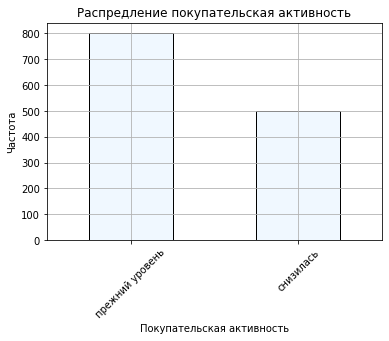

In [25]:
mf['покупательская активность'].value_counts().plot(kind='bar', color='aliceblue', edgecolor='black')
plt.title('Распредление покупательская активность')
plt.xlabel('Покупательская активность')
plt.ylabel('Частота')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

**Комментарий:** Исходя из графика распределения признака `покупательская активность`, который имеет два значения `прежний уровень` и `снизилась` можно сказать, что активность большинства пользователей не изменилась, однако примерно 500 пользователей понизили свою активность.

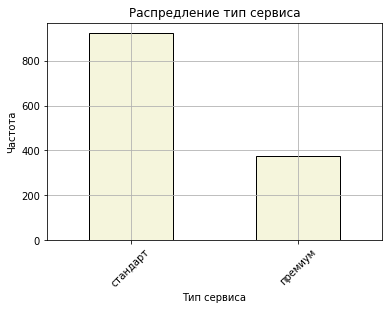

In [26]:
mf['тип сервиса'].value_counts().plot(kind='bar', color='beige', edgecolor='black')
plt.title('Распредление тип сервиса')
plt.xlabel('Тип сервиса')
plt.ylabel('Частота')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

**Комментарий**: На графике распределения признака `тип сервиса` заметно, что большинство пользователей имеют тип сервиса `стандарт`(>850 пользователей), а у остальных пользователей(~380) тип-`премиум`

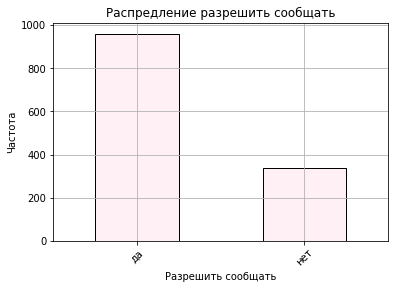

In [27]:
mf['разрешить сообщать'].value_counts().plot(kind='bar', color='lavenderblush', edgecolor='black')
plt.title('Распредление разрешить сообщать')
plt.xlabel('Разрешить сообщать')
plt.ylabel('Частота')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

**Комментарий**: На графике видно, что примерно `950` пользователей дали разрешение на получение рассылок, а примерно `350` ответили отказом на запрос отправки рассылок.

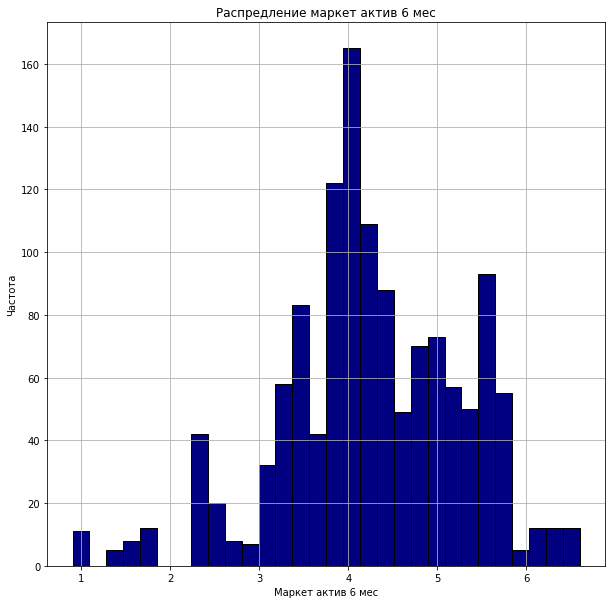

In [28]:
plt.figure(figsize=(10,10))
plt.hist(mf['маркет актив 6 мес'], bins=30, color='navy', edgecolor='black')
plt.title('Распредление маркет актив 6 мес')
plt.xlabel('Маркет актив 6 мес')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

**Комментарий**: На графике видно, что на большинство клиентов приходиться по `4` маркетинговые коммуникации за месяц, данные распределены в пределах от 1 до ~6.5

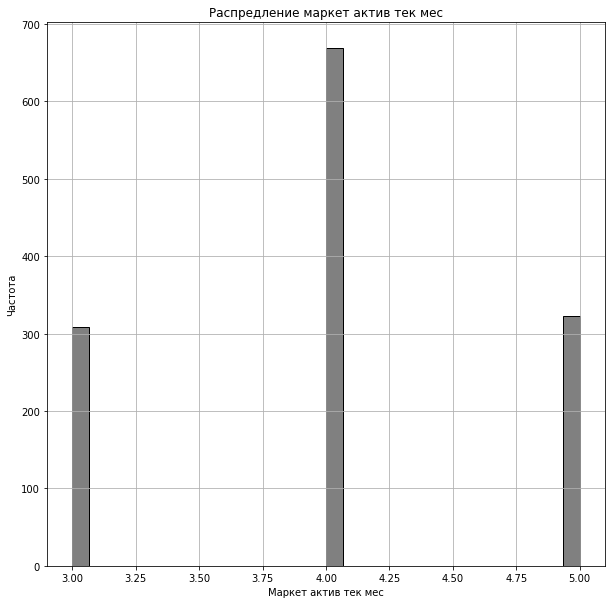

In [29]:
plt.figure(figsize=(10,10))
plt.hist(mf['маркет актив тек мес'], bins=30, color='grey', edgecolor='black')
plt.title('Распредление маркет актив тек мес')
plt.xlabel('Маркет актив тек мес')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

**Комментарий**: В текущем месяце у большинства пользователей (>650) `4` маркетинговые коммуникации, оставшиеся пользователи (~300) имеют значение - `1` маркетинговая коммуникация и ~315 пользователей получают `5` рассылок или звонков за текущий месяц.

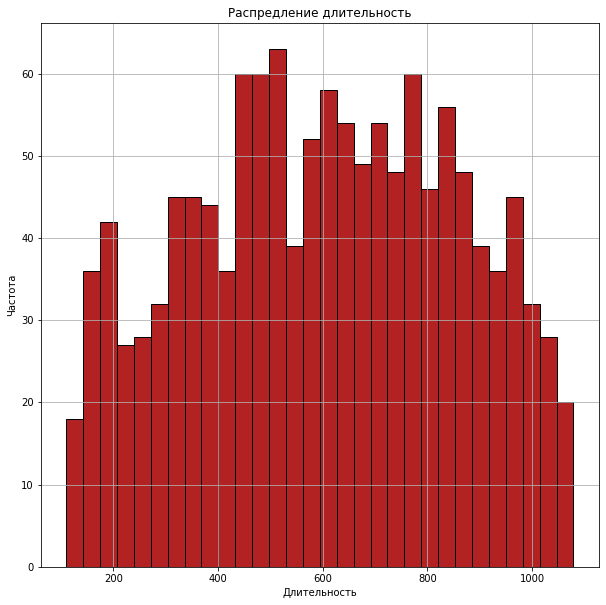

In [30]:
plt.figure(figsize=(10,10))
plt.hist(mf['длительность'], bins=30, color='firebrick', edgecolor='black')
plt.title('Распредление длительность')
plt.xlabel('Длительность')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

**Комменатрий**: На графике нет сильно выделяющихся пиков или спадов, но самый распространённый диапозон длительсноти опредлен от `400` до `900` дней с момента регистрации. Максимум в значении `500`-около 63 пользователей.

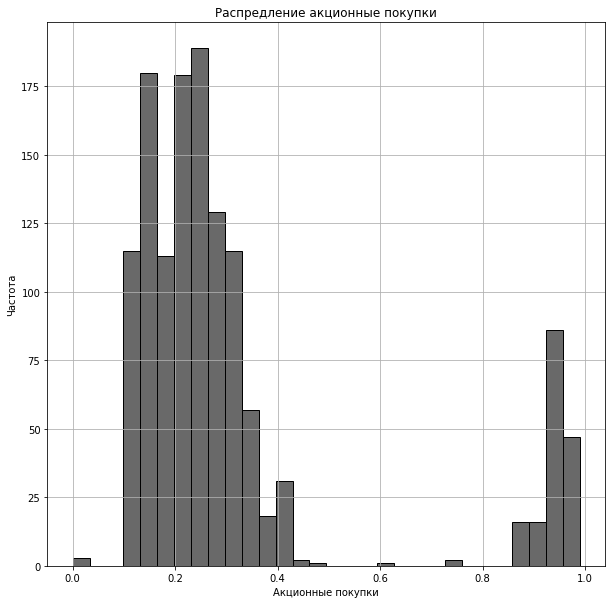

In [31]:
plt.figure(figsize=(10,10))
plt.hist(mf['акционные покупки'], bins=30, color='dimgray', edgecolor='black')
plt.title('Распредление акционные покупки')
plt.xlabel('Акционные покупки')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

**Комментарий**: На графике видно, что в среднем за месяц пользователи пользуются акциями в течении полугода около `0.1`-`0.3`, пик графика находится в значении `~0.3`(~185 пользователей). Диапозон значений от `0` до `0.99`

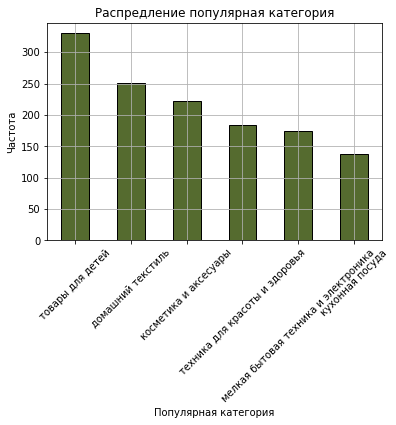

In [32]:
mf['популярная категория'].value_counts().plot(kind='bar', color='darkolivegreen', edgecolor='black')
plt.title('Распредление популярная категория')
plt.xlabel('Популярная категория')
plt.ylabel('Частота')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

**КОмментарий**: Исходя из графика распределения можно сказать, что самая популярная категория у пользователей это-`товары для детей`, около `370` пользователей совершают покупки в ней в течении полугода, наименьшей популярностью среди пользователей обладает категории `мелкой бытовой техники и электроники, кухонной посуды` примерно `~140` пользователей заинтересовались ей в течении полугода.

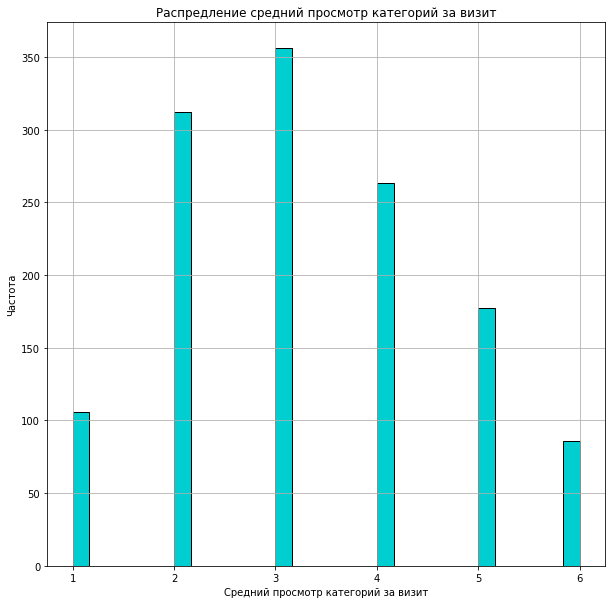

In [33]:
plt.figure(figsize=(10,10))
plt.hist(mf['средний просмотр категорий за визит'], bins=30, color='darkturquoise', edgecolor='black')
plt.title('Распредление средний просмотр категорий за визит')
plt.xlabel('Средний просмотр категорий за визит')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

**Комментарий**: Большинство пользователей(>350) выделяют для себя `3` категории за визит, есть и те кто просматривает все категории за визит, таких около `75`, а есть пользователей, которых интересует только одна категория и их около `100`.

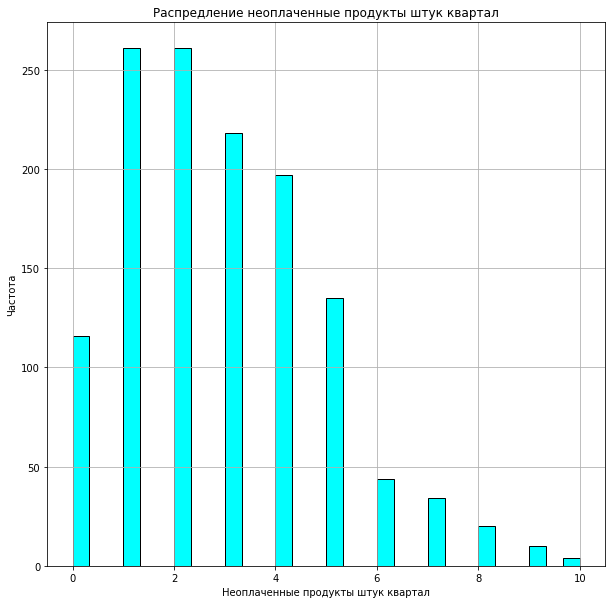

In [34]:
plt.figure(figsize=(10,10))
plt.hist(mf['неоплаченные продукты штук квартал'], bins=30, color='cyan', edgecolor='black')
plt.title('Распредление неоплаченные продукты штук квартал')
plt.xlabel('Неоплаченные продукты штук квартал')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

**Комментарий**: Большинство пользователей держат у себя `1`-`2` неоплаченных товара в корзине, таких пользователей около `520`. Есть и те у которых в корзине нет неоплаченных товаров их `~115`, общий диапозон определен на отрезке от 0 до 10, тех кто имеет от 6 до 10 неоплаченных товаров совсем мало - около `150` пользоваталей

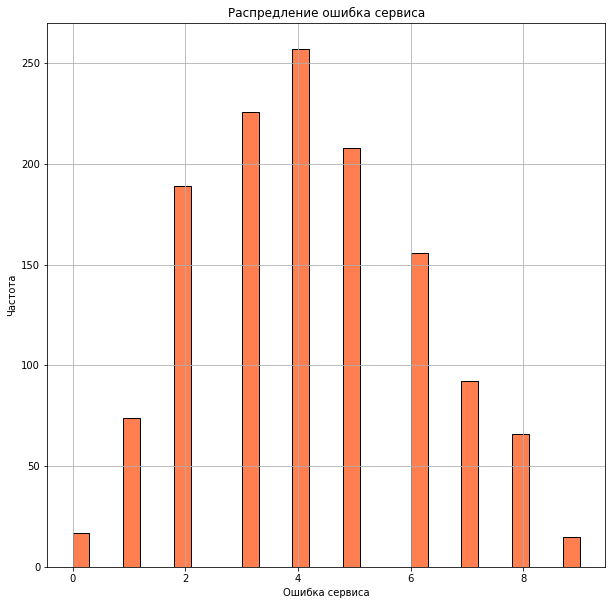

In [35]:
plt.figure(figsize=(10,10))
plt.hist(mf['ошибка сервиса'], bins=30, color='coral', edgecolor='black')
plt.title('Распредление ошибка сервиса')
plt.xlabel('Ошибка сервиса')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

**Комменатрий**: Большенство пользоватаелй столкнулись с `4` сбоями во время использования сайта, таких пользователей около `250`, диапозон числа сбоев распределен от `0` до `9`, меньше всего пользователей сталкивались с `9` сбоями или вовсе не сталкивались

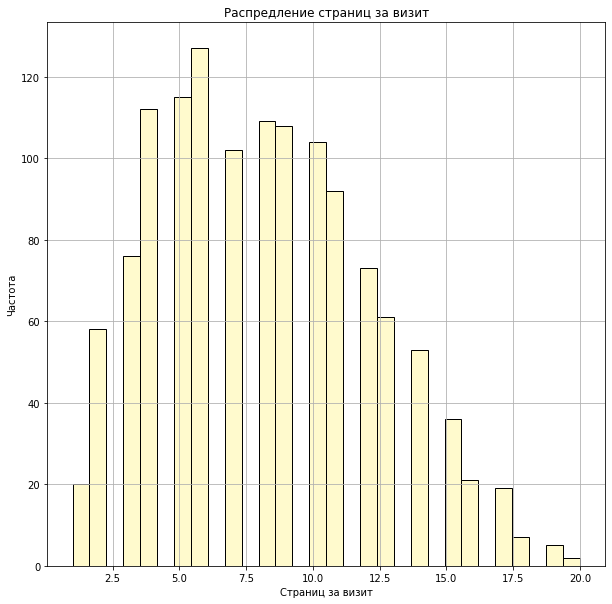

In [36]:
plt.figure(figsize=(10,10))
plt.hist(mf['страниц за визит'], bins=30, color='lemonchiffon', edgecolor='black')
plt.title('Распредление страниц за визит')
plt.xlabel('Страниц за визит')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

**Комментарий**: Больше всего пользователей посещают в среднем за визит около `6` страниц, диапозон значений определен от `1` до `20` страниц. Меньше всего пользователей, которые посещают более `15` страниц.

Ниже графики для mm(market_money)

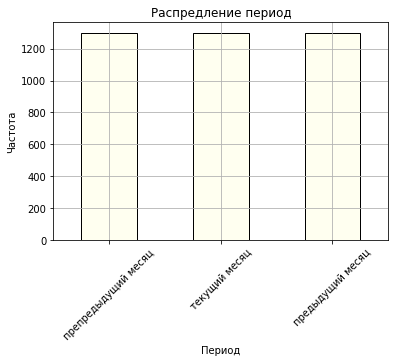

In [37]:
mm['период'].value_counts().plot(kind='bar', color='ivory', edgecolor='black')
plt.title('Распредление период')
plt.xlabel('Период')
plt.ylabel('Частота')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

**Комментарий**: Данные распределены абсолютно равномерно, каждой значение достигает частоту в `1300`

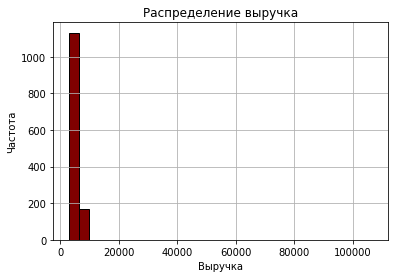

In [38]:
plt.hist(mm[mm['период']=='текущий месяц']['выручка'], bins=30, color='maroon', edgecolor='black')
plt.title('Распределение выручка')
plt.xlabel('Выручка')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

In [39]:
mm.describe()

,id,выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


In [40]:
max_value = mm['выручка'].max()
second_max = mm['выручка'].nlargest(2).iloc[1]
print('Максимальное значение:', max_value)
print('Второе по величине:', second_max)

Максимальное значение: 106862.2
Второе по величине: 7799.4


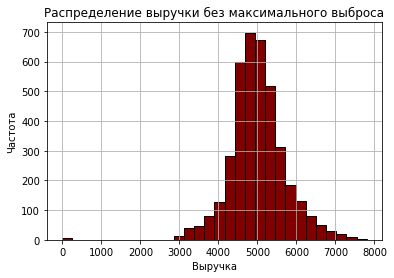

In [41]:
max_value = mm['выручка'].max()
mm_wo_max = mm[mm['выручка'] != max_value]
plt.hist(mm_wo_max['выручка'], bins=30, color='maroon', edgecolor='black')
plt.title('Распределение выручки без максимального выброса')
plt.xlabel('Выручка')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

**Комменатрий**: Первичный анализ показал наличие одного экстремального выброса в данных по выручке: максимальное значение составляет 106862.2, в то время как второе по величине — 7799.4. Это говорит о том, что выброс действительно единичный и сильно отличается от всех остальных наблюдений. После исключения этого максимального значения распределение выручки приобрело нормальный вид без выраженных хвостов

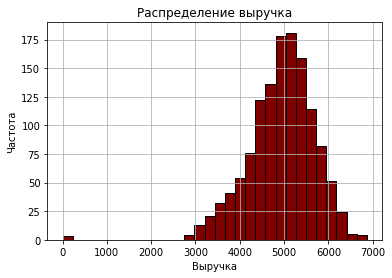

In [42]:
plt.hist(mm[mm['период']=='предыдущий месяц']['выручка'], bins=30, color='maroon', edgecolor='black')
plt.title('Распределение выручка')
plt.xlabel('Выручка')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

**Комментарий**: Распределение выручки за предыдущий месяц близко к нормальному: большинство покупателей имеют средние значения выручки, а экстремальные значения встречаются редко

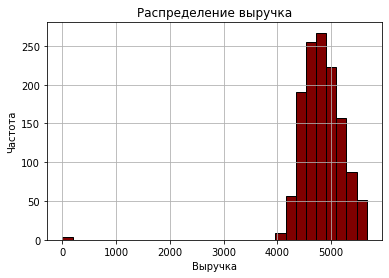

In [43]:
plt.hist(mm[mm['период']=='препредыдущий месяц']['выручка'], bins=30, color='maroon', edgecolor='black')
plt.title('Распределение выручка')
plt.xlabel('Выручка')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

**Комменатрий**: Распределение выручки смещено вправо, основная масса покупателей приносит выручку в диапазоне от 4000 до 5500. Практически отсутствуют как очень низкие, так и очень высокие значения выручки — структура стабильная, а единичные нулевые значения могут быть выбросами или отсутствием активности.

Ниже графики для mt(market_time)

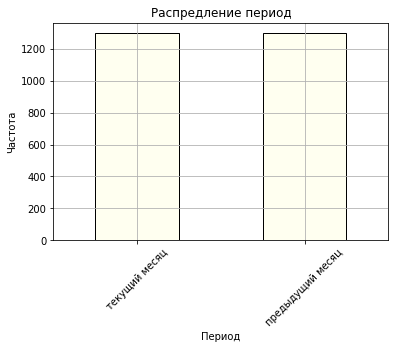

In [44]:
mt['период'].value_counts().plot(kind='bar', color='ivory', edgecolor='black')
plt.title('Распредление период')
plt.xlabel('Период')
plt.ylabel('Частота')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

**Комментарий:** Данные распределены абсолютно равномерно, каждой значение достигает частоту в 1300

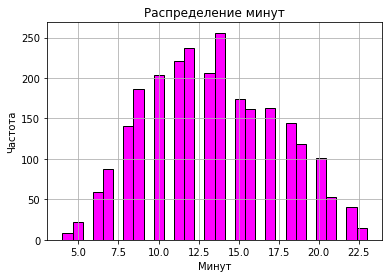

In [45]:
plt.hist(mt['минут'], bins=30, color='magenta', edgecolor='black')
plt.title('Распределение минут')
plt.xlabel('Минут')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

**Комменатрий**: Большинство пользователей затрачивают от `8` до `14` минут на сайте, диапозон опредлен на отрезке от `4.5` до `23` минут.

Ниже графики для mn(money)

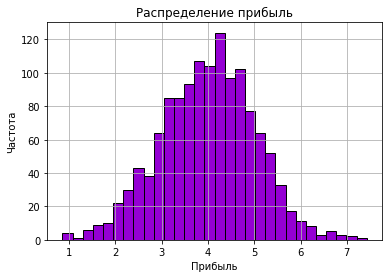

In [46]:
plt.hist(mn['прибыль'], bins=30, color='darkviolet', edgecolor='black')
plt.title('Распределение прибыль')
plt.xlabel('Прибыль')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

**Комменатрий**: График отражает распределение прибыли, где большинство значений сосредоточено в диапазоне от 3 до 5.
Распределение близко к симметричному, что говорит о нормальном характере прибыли для основной части наблюдений.

**Отберем клиентов, которые совершали покупки за псоледние 3 месяца**

In [47]:
df_with_sales = mm[mm['выручка'] > 0]
sales_count = df_with_sales.groupby('id').size().reset_index(name='months_with_sales')
active_clients = sales_count[sales_count['months_with_sales'] >= 3]
active_client_ids = active_clients['id'].tolist()
filtered_df = mm[mm['id'].isin(active_client_ids)]

**Вывводы после исследовательского анализа**: Был проведен графический анализ распределения каждого признака из каждого файла с последующеми комментариями к каждому графику, также были отобраны пользователи, имеющие активность за последние 3 месяца.

In [48]:
mm = mm[mm['выручка'] != 0]

## Объединение таблиц

### Объединение таблиц market_file.csv, market_money.csv, market_time.csv

### Добавление отдельного столбца для каждого периода

In [49]:
mm_pivot=mm.pivot(index='id', columns='период', values='выручка')
mm_pivot.columns=[f'выручка {col}' for col in mm_pivot.columns]
mm_pivot=mm_pivot.reset_index()

mt_pivot=mt.pivot(index='id', columns='период', values='минут')
mt_pivot.columns=[f'минут {col}' for col in mt_pivot.columns]
mt_pivot = mt_pivot.reset_index()

df_merged = mf.merge(mm_pivot, on='id', how='left').merge(mt_pivot, on='id', how='left')
df_merged.head()

,id,покупательская активность,тип сервиса,разрешить сообщать,маркет актив 6 мес,маркет актив тек мес,длительность,акционные покупки,популярная категория,средний просмотр категорий за визит,неоплаченные продукты штук квартал,ошибка сервиса,страниц за визит,выручка предыдущий месяц,выручка препредыдущий месяц,выручка текущий месяц,минут предыдущий месяц,минут текущий месяц
0,215348,снизилась,премиум,да,3.4,5,121,0.00,товары для детей,6,2,1,5,NaN,NaN,3293.1,13,14
1,215349,снизилась,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11


**Комментарий**: Теперь у нас есть таблица, в которой все данные из `market_file` и сведения о выручки и времени из файлов `market_money` и `market_time`.

## Корреляционный анализ

interval columns not set, guessing: ['id', 'маркет актив 6 мес', 'маркет актив тек мес', 'длительность', 'акционные покупки', 'средний просмотр категорий за визит', 'неоплаченные продукты штук квартал', 'ошибка сервиса', 'страниц за визит', 'выручка предыдущий месяц', 'выручка препредыдущий месяц', 'выручка текущий месяц', 'минут предыдущий месяц', 'минут текущий месяц']


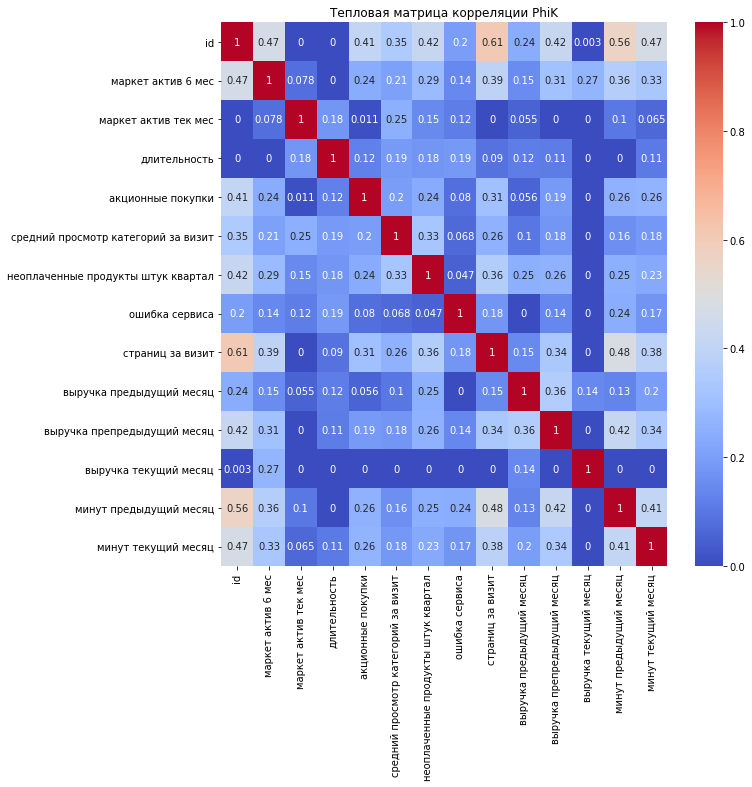

In [50]:
phik_matrix = df_merged.select_dtypes(include=[np.number]).phik_matrix()
plt.figure(figsize=(10, 10))
sns.heatmap(phik_matrix, cmap='coolwarm', annot=True) 
plt.title('Тепловая матрица корреляции PhiK')
plt.show()

**Вывод**: Мультиколлинеарности нет.

## Использование пайплайнов

### Обработка данных

In [51]:
RANDOM_STATE=44
X = df_merged.drop(['покупательская активность'], axis=1)
y = df_merged['покупательская активность']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

y_train = y_train.map({'прежний уровень': 0, 'снизилась': 1})
y_test = y_test.map({'прежний уровень': 0, 'снизилась': 1})
ohe_columns = ['разрешить сообщать', 'популярная категория']
ord_columns = ['тип сервиса']
num_columns = df_merged.columns.drop(['разрешить сообщать', 'популярная категория', 'покупательская активность', 'тип сервиса', 'id'])

ohe_pipe = Pipeline([('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))])

ord_pipe = Pipeline([('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')), 
                    ('ord', OrdinalEncoder(categories=[
                        ['стандарт', 'премиум']
                    ], handle_unknown='use_encoded_value', unknown_value=np.nan)),
                    ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))])

preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns),
    ('ord', ord_pipe, ord_columns),
    ('num', MinMaxScaler(), num_columns)
], remainder='passthrough')

**Комменатрий**: В коде выше есть две строчки, которые переводят целевой признак `покупательская активностЬ` в бинарный вид, где 
`1`-снизилась, а `0`-прежний уровень.

**Выбор метрики:** В данной задаче лучше использовать `f1` метрику, т.к. нам важно не упускать клиентов чья активность снизилась, но и при этом не делать звонки, рассылки и т.д. всем подряд

### Обучение четырех моделей

In [52]:
pipe_final = Pipeline([
    ('preprocessor', preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    },
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE)],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    },
    {
        'models':  [SVC(probability=True, random_state=RANDOM_STATE)],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()] 
    }
]
grid = GridSearchCV(pipe_final, param_grid=param_grid, scoring='f1', n_jobs=-1)
grid.fit(X_train.drop(['id'], axis=1), y_train)
display('Лучшая модель и её параметры:\n\n', grid.best_estimator_)
display('Значение метрики:\n\n', grid.best_score_)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
110 fits failed out of a total of 140.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/opt/conda/lib/python

'Лучшая модель и её параметры:\n\n'

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['разрешить сообщать',
                                                   'популярная категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strat...
                                                  Index(['маркет актив 6 мес', 'маркет актив тек мес', 'длительность',
       'акционные покупки', 'средний просмотр категорий за визит',
       'неоплаченные продукты штук квартал', 'ошибка сервиса',
       'страниц за визит', 'выручка предыдущий месяц',
       'выручка препредыдущий месяц', 'выручка текущий месяц',
       'минут предыдущий месяц', 'минут текущий месяц'],
      dtype='object'))])),
                ('models',
                 DecisionTreeClassifier(max_depth=4, random_state=44))])

'Значение метрики:\n\n'

0.792779723890759

### Выбор лучшей модели

**Комментарий**: В результате подбора гиперпараметров лучшей оказалась модель DecisionTreeClassifier с гиперпараметром `max_depth`=4

In [53]:
best_model = grid.best_estimator_.named_steps['models']
X_test_t = grid.best_estimator_.named_steps['preprocessor'].transform(X_test.drop(['id'], axis=1))
prediction = grid.predict(X_test.drop(['id'], axis=1))
display('f1-', f1_score(y_test, prediction))

'f1-'

0.759825327510917

**Комментарий**: На тестовой выборке результат `f1` метрики чуть ниже (0.75).

## Важность признаков

### Оценка важности каждого признака SHAP

In [54]:
ohe = grid.best_estimator_.named_steps['preprocessor'].named_transformers_['ohe'].named_steps['ohe']
ohe_features = ohe.get_feature_names_out(ohe_columns)
num_features = num_columns
ord_features = ord_columns
feature_names = list(ohe_features) + list(ord_features) + list(num_features)

In [55]:
X_train_transformed = grid.best_estimator_.named_steps['preprocessor'].transform(X_train.drop(['id'], axis=1))

In [56]:
model = grid.best_estimator_.named_steps['models']
background = shap.sample(X_train_transformed, 100)
explainer = shap.KernelExplainer(model.predict_proba, background)
shap_values = explainer.shap_values(X_train_transformed[:100])

  0%|          | 0/100 [00:00<?, ?it/s]

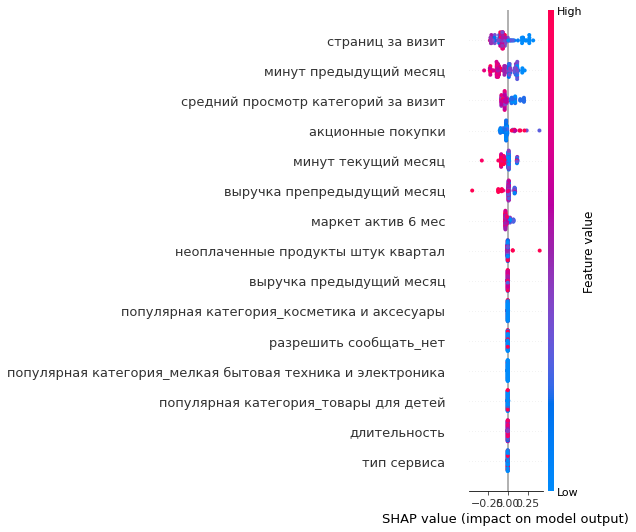

In [57]:
shap.summary_plot(shap_values[:, :, 1], X_train_transformed[:100], feature_names=feature_names, max_display=15)

### DВывод по оценке важности признаков

**Вывод**: Наибольшее влияние на целевой признак оказывают «страниц за визит», «минут предыдущий месяц» и «средний просмотр категорий за визит» — именно эти признаки модель использует чаще всего для принятия решения. Наименее значимыми оказались «выручка текущий месяц» и «ошибка сервиса», их вклад в результат минимален.

## Сегментация покупателей

### Выполнение сегментации

In [58]:
best_pipe = grid.best_estimator_
prediction = best_pipe.predict_proba(df_merged)
X_test_pred = df_merged.copy()
X_test_pred['покупательская активность снизилась'] = prediction[:, 1]
X_test_pred = X_test_pred.reset_index()
X_test_pred = X_test_pred.merge(mn, on='id', how='left')

**Комменатрий**: Была создана таблица со всеми признаками из `df_merged` и значениями прибыли с каждого клиента по `id`

In [59]:
profit_median = X_test_pred['прибыль'].median()
churn_median = X_test_pred['покупательская активность снизилась'].median()

def segment(row):
    if row['прибыль'] >= profit_median:
        if row['покупательская активность снизилась'] >= churn_median:
            return 'VIP-рисковые'
        else:
            return 'VIP-лояльные'
    else:
        if row['покупательская активность снизилась'] >= churn_median:
            return 'обычные-рисковые'
        else:
            return 'обычные-лояльные'

X_test_pred['сегмент'] = X_test_pred.apply(segment, axis=1)
display(X_test_pred.head(10))

,index,id,покупательская активность,тип сервиса,разрешить сообщать,маркет актив 6 мес,маркет актив тек мес,длительность,акционные покупки,популярная категория,...,ошибка сервиса,страниц за визит,выручка предыдущий месяц,выручка препредыдущий месяц,выручка текущий месяц,минут предыдущий месяц,минут текущий месяц,покупательская активность снизилась,прибыль,сегмент
0,0,215348,снизилась,премиум,да,3.4,5,121,0.00,товары для детей,...,1,5,NaN,NaN,3293.1,13,14,0.960352,0.98,обычные-рисковые
1,1,215349,снизилась,премиум,да,4.4,4,819,0.75,товары для детей,...,2,5,5216.0,4472.0,4971.6,12,10,0.960352,4.16,VIP-рисковые
2,2,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний текстиль,...,1,5,5457.5,4826.0,5058.4,8,13,0.960352,3.13,обычные-рисковые
3,3,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары для детей,...,6,4,6158.0,4793.0,6610.4,11,13,0.960352,4.87,VIP-рисковые
4,4,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары для детей,...,3,2,5807.5,4594.0,5872.5,8,11,0.960352,4.21,VIP-рисковые
5,5,215353,снизилась,стандарт,да,3.3,4,762,0.26,домашний текстиль,...,1,4,4738.5,5124.0,5388.5,10,10,0.960352,3.95,обычные-рисковые
6,6,215354,снизилась,стандарт,да,5.1,3,431,0.23,косметика и аксесуары,...,7,2,5685.0,4503.0,5869.6,11,12,0.960352,3.62,обычные-рисковые
7,7,215355,снизилась,стандарт,нет,4.7,4,284,0.17,товары для детей,...,6,4,3263.0,4749.0,3772.6,12,10,0.960352,5.26,VIP-рисковые
8,8,215356,снизилась,стандарт,да,4.2,4,192,0.14,косметика и аксесуары,...,1,3,4146.5,4433.0,4566.4,6,7,0.960352,4.93,VIP-рисковые
9,9,215357,снизилась,стандарт,да,3.9,5,154,0.00,техника для красоты и здоровья,...,9,5,NaN,NaN,5986.3,12,6,0.960352,4.66,VIP-рисковые


**Комментарий**: Была создана функция, которая записывает в новый признак `сегмент`, к какому сегменту относится пользователь. 
```
Высокая прибыль и снижение активности - VIP рисковые
Высокая прибыль и прежний уровень активности - VIP лояльные
Низкая прибыль и снижение активности - обычные рисковые
Низкая прибыль и прежняя активность - обычные лояльные
```

### Выбор группы для увелечения покупательской активности

**Предложение по увеличению покупательской активности группы:** Группа чью активность стоит повышать, это `VIP-рисковые`, т.к. есть вероятность потери клиентов с высокой прибылью.

In [60]:
risk_vip = X_test_pred[
    (X_test_pred['покупательская активность снизилась'] > 0.5) &
    (X_test_pred['прибыль'] > X_test_pred['прибыль'].median())
]

nrisk = X_test_pred[
    (
        ((X_test_pred['покупательская активность снизилась'] < 0.5) & (X_test_pred['прибыль'] > X_test_pred['прибыль'].median())) |
        ((X_test_pred['покупательская активность снизилась'] < 0.5) & (X_test_pred['прибыль'] < X_test_pred['прибыль'].median()))
    )
]

**Комментарий**: `risk_vip` - Клиенты с высокой прибылью  и снижением уровня активности. `nrisk` - лояльные клиенты и с высокой прибыль и с низкой.

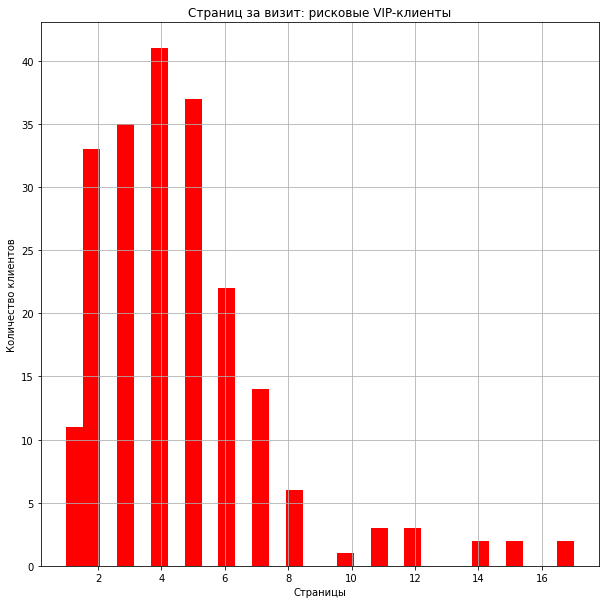

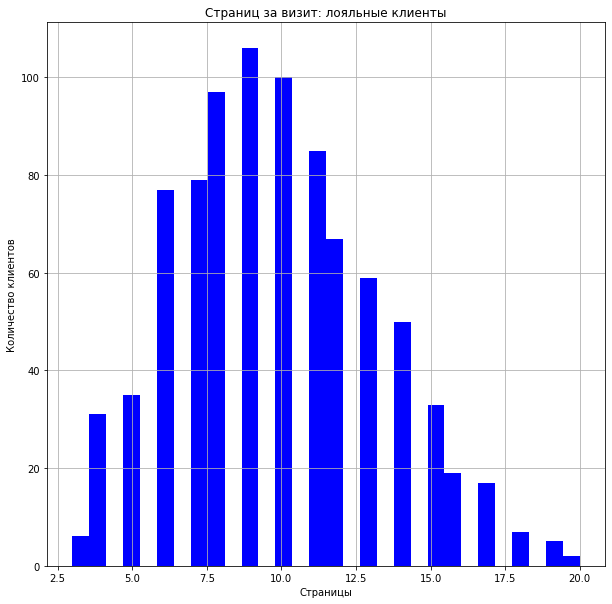

In [61]:
risk_vip['страниц за визит'].plot(kind='hist', bins=30, color='red', figsize=(10,10))
plt.title('Страниц за визит: рисковые VIP-клиенты')
plt.xlabel('Страницы')
plt.grid(True)
plt.ylabel('Количество клиентов')
plt.show()
nrisk['страниц за визит'].plot(kind='hist', bins=30, color='blue', figsize=(10,10))
plt.title('Страниц за визит: лояльные клиенты')
plt.xlabel('Страницы')
plt.grid(True)
plt.ylabel('Количество клиентов')
plt.show()

**Комментарий**: Рисковые VIP клиенты просматривают от 2 до 6 страниц за визит, что очень мало в сравнении с лояльными клиентам, которые просматривают от 7 до 13 страниц за визит.

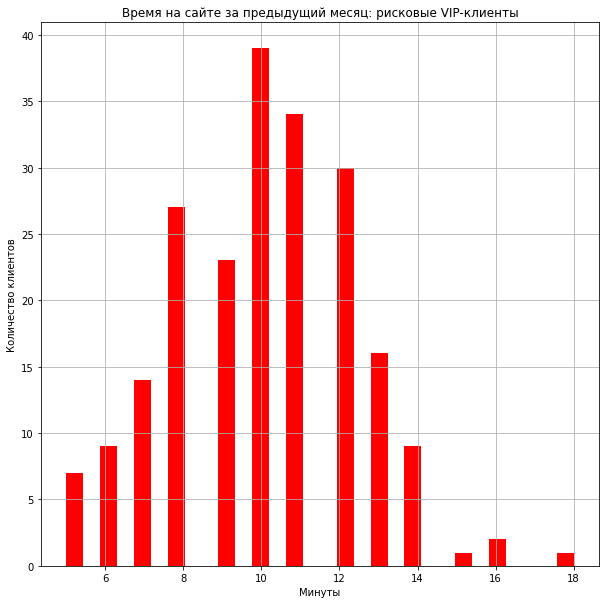

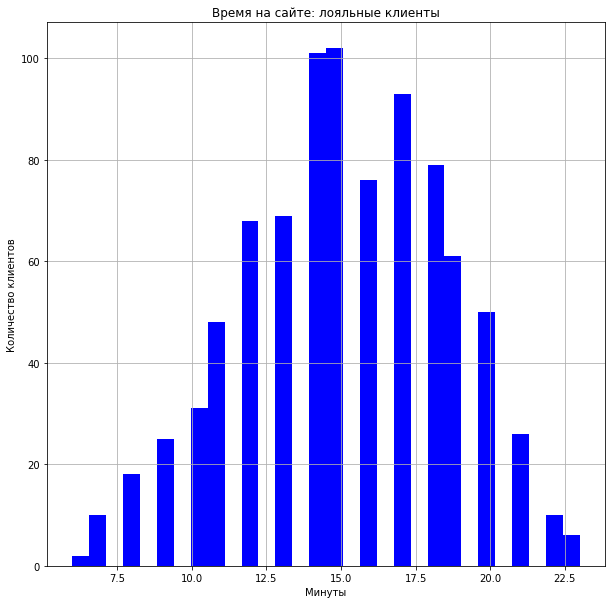

In [62]:
risk_vip['минут предыдущий месяц'].plot(kind='hist', bins=30, color='red', figsize=(10,10))
plt.title('Время на сайте за предыдущий месяц: рисковые VIP-клиенты')
plt.xlabel('Минуты')
plt.grid(True)
plt.ylabel('Количество клиентов')
plt.show()
nrisk['минут предыдущий месяц'].plot(kind='hist', bins=30, color='blue', figsize=(10,10))
plt.title('Время на сайте: лояльные клиенты')
plt.xlabel('Минуты')
plt.grid(True)
plt.ylabel('Количество клиентов')
plt.show()

**Комментарий**: VIP клиенты в предыдущем месяце проводили на сайте от 10 до 12 минут. В то время лояльные клиенты проводили на сайте от 14 до 18 минут.

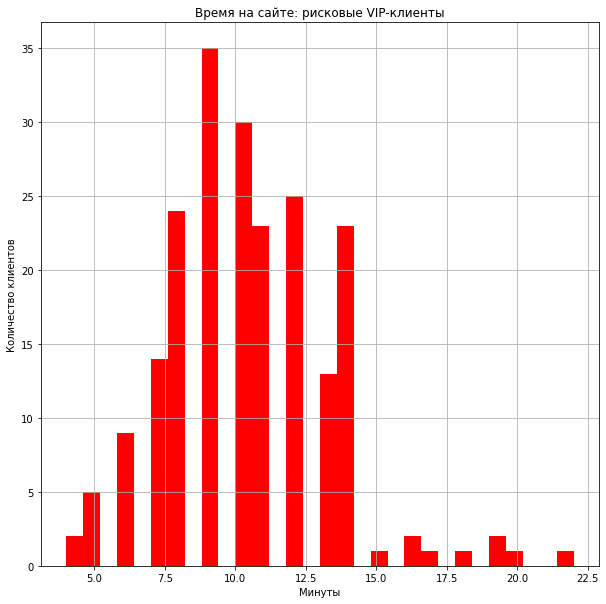

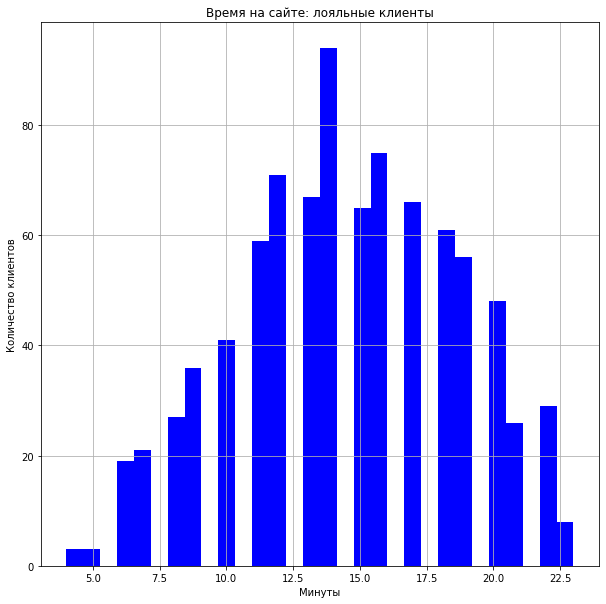

In [63]:
risk_vip['минут текущий месяц'].plot(kind='hist', bins=30, color='red', figsize=(10,10))
plt.title('Время на сайте: рисковые VIP-клиенты')
plt.xlabel('Минуты')
plt.grid(True)
plt.ylabel('Количество клиентов')
plt.show()
nrisk['минут текущий месяц'].plot(kind='hist', bins=30, color='blue', figsize=(10,10))
plt.title('Время на сайте: лояльные клиенты')
plt.xlabel('Минуты')
plt.grid(True)
plt.ylabel('Количество клиентов')
plt.show()

**Комментарий и предложение**: Распределение времени на сайте для рисковых VIP-клиентов показывает, что большинство из них проводят на сайте всего 8–12 минут в месяц, хотя в прошлом месяце значение было в диапозоне от 10 до 12. Это относительно мало для клиентов с высокой прибылью, ведь лояльные клиенты проводят в текущем месяце от 12 до 17 минут на сайте, это может свидетельствовать о снижении интереса или вовлечённости. Для повышения активности этой группы рекомендуется усилить индивидуальные предложения, например, персональные акции, рекомендации товаров, а также дополнительные бонусы за активность. Также можно повысить вовлечённость через полезный контент, персональные рассылки и специальные условия для VIP-клиентов.

### Вывод после сегментации

# Выводы о сегментах

**Какой сегмент выбран:**  
Для дополнительного исследования были выбраны рискованные VIP-клиенты с высокой прибылью, у которых модель предсказывает высокую вероятность снижения покупательской активности.

**Предложения и причины:**
1. Усилить персонализированные акции и товарные рекомендации для этой группы, чтобы повысить вовлечённость и вернуть интерес к покупкам.
2. Ввести дополнительные бонусы, полезный контент и специальные условия для VIP-клиентов — это поможет удержать их на сайте и снизить вероятность снижения активности.


## Итоговый вывод

# Общий вывод

# 1. Описание задачи
Целью проекта было спрогнозировать снижение покупательской активности клиентов интернет-магазина на основе их исторического поведения и профиля, а также выделить группы покупателей для дальнейшей работы по повышению вовлечённости.

# 2. Исходные данные и проведённая предобработка
Использовались четыре датасета: информация о клиентах, история выручки, история прибыли и история времени на сайте. Данные были объединены по `id`, обработаны пропуски, выбросы, преобразованы типы данных. Категориальные признаки закодированы, выделены новые информативные признаки (например, выручка и время в текущем и предыдущем месяцах). Удален избыточный признак с высокой корреляцией.

# 3. Поиск лучшей модели
Построен пайплайн с масштабированием и обработкой категориальных и числовых признаков. Опробованы разные алгоритмы (Logistic Regression, Random Forest, SVC) с подбором гиперпараметров через GridSearchCV. Для оценки качества использована метрика f1. Важность признаков проанализирована с помощью SHAP.

# 4. Лучшая модель
Лучшие результаты показала **SVC** с настройкой гиперпараметров. Модель продемонстрировала высокое качество. Наибольшее влияние на предсказания оказали признаки: `страниц за визит`, `минуты за текущий и предыдущий месяц`, `средний просмотр категорий`, `неоплаченные продукты`. Наименее значимыми оказались некоторые категориальные признаки.

# 5. Выводы и предложения по выбранному сегменту
Для дополнительного анализа был выбран сегмент **клиентов с высокой прибылью, но снижением активности**. Анализ показал, что эти клиенты стали тратить на сайте меньше времени и просматривать меньше страниц, чем лояльные клиенты.

**Рекомендации:**
- Усилить персонализацию (индивидуальные акции, рекомендации, спецусловия).
- Повысить вовлечённость через персональные рассылки и полезный контент.
- Ввести дополнительные бонусы и кешбэк за активность.
- Анализировать опыт клиентов и устранить возможные препятствия на сайте.

---

В целом, модель эффективно прогнозирует снижение активности клиентов, а предложенные меры могут помочь удержать ценный сегмент покупателей и повысить их вовлечённость.
